In [1]:
import os
import glob
import spacy
import random
import warnings
from matplotlib import pyplot as plt
from collections import Counter
from nltk import ngrams
import re
import pandas as pd
import seaborn as sns

# set the random seed for reproducibility
random.seed(123)
# turn off depreciation warnings and future warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# function to load data
def load_data(base_dir):
    data = []
    labels = []
    files = []
    for label in ['positive', 'negative']:
        for filepath in glob.glob(os.path.join(base_dir, label, '*.txt')):
            with open(filepath, 'r', encoding='utf-8') as file:
                data.append(file.read())
                labels.append(1 if label == 'positive' else 0)
                files.append(filepath)
                
    return data, labels, files

# delete the contents after (What I.*? and why)
def clean_data(data):
    cleaned_data = []
    pattern = re.compile(r'(What I.*? and why)')
    for text in data:
        parts = pattern.split(text)
        if len(parts) == 1:
            raise ValueError('No text found')
        cleaned_data.append(parts[0])
    return cleaned_data

In [3]:
# load training data
train_data, train_labels, train_files = load_data('data/train')
# load test data
test_data, test_labels, test_files = load_data('data/test')

train_data = clean_data(train_data)
test_data = clean_data(test_data)

# load spacy model
nlp = spacy.load('en_core_web_lg')

# preprocess the texts
def preprocess_texts(texts):
    docs = [nlp(text) for text in texts]
    return docs

# preprocess the training data
train_docs = preprocess_texts(train_data)
# backup the training data for later use
train_docs_backup = train_docs
# preprocess the test data
test_docs = preprocess_texts(test_data)

In [4]:
# function to remove stopwords and punctuation
def remove_stopwords_punctuation(docs):
    cleaned_docs = []
    for doc in docs:
        doc = [token for token in doc if not token.is_stop and not token.is_punct]
        doc = [token for token in doc if token.text not in ['\n', 'Mr', 'Mrs', 'Miss', 'Ms']]
        doc = [token for token in doc if len(token.text) > 1]
        cleaned_docs.append(doc)
    return cleaned_docs

#  lowercase and lemmatise the tokens
def lowercase_and_lemmatise(docs):
    lemmatised_docs = []
    for doc in docs:
        lemmatised_tokens = [token.lemma_.lower() for token in doc]
        lemmatised_docs.append(lemmatised_tokens)
    return lemmatised_docs

# remove stopwords and punctuation from the training data
train_docs = remove_stopwords_punctuation(train_docs)
# remove stopwords and punctuation from the test data
test_docs = remove_stopwords_punctuation(test_docs)

# lowercase and lemmatise the training data
train_docs = lowercase_and_lemmatise(train_docs)
# lowercase and lemmatise the test data
test_docs = lowercase_and_lemmatise(test_docs)

# split the training data into positive and negative reviews
positive_train_docs = [train_docs[i] for i in range(len(train_docs)) if train_labels[i] == 1]
negative_train_docs = [train_docs[i] for i in range(len(train_docs)) if train_labels[i] == 0]


## Compute the Most Common N-grams

In [5]:
# function to extract n-grams
def extract_ngrams(docs, n):
    ngram_counts = Counter()
    for doc in docs:
        ngram_counts.update(ngrams(doc, n))
    return ngram_counts

# extract n-grams for positive and negative documents
positive_unigrams = extract_ngrams(positive_train_docs, 1)
negative_unigrams = extract_ngrams(negative_train_docs, 1)
positive_bigrams = extract_ngrams(positive_train_docs, 2)
negative_bigrams = extract_ngrams(negative_train_docs, 2)
positive_trigrams = extract_ngrams(positive_train_docs, 3)
negative_trigrams = extract_ngrams(negative_train_docs, 3)
positive_fourgrams = extract_ngrams(positive_train_docs, 4)
negative_fourgrams = extract_ngrams(negative_train_docs, 4)

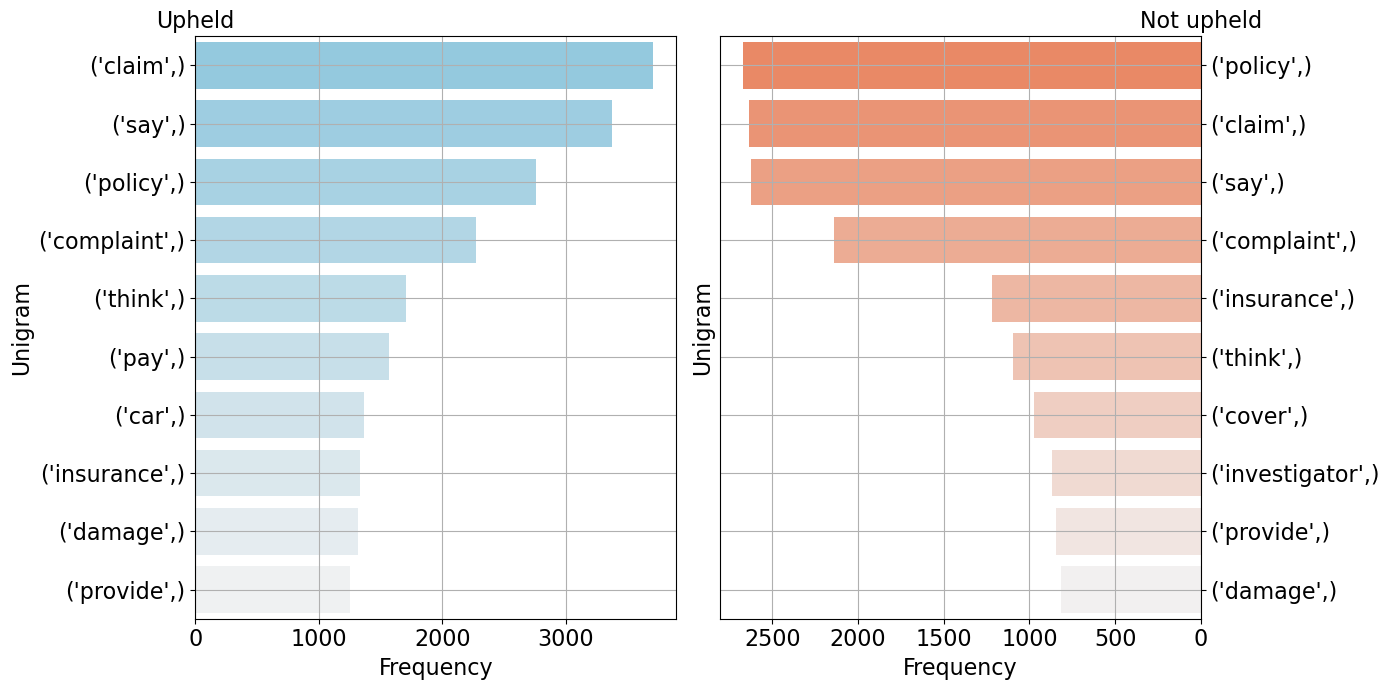

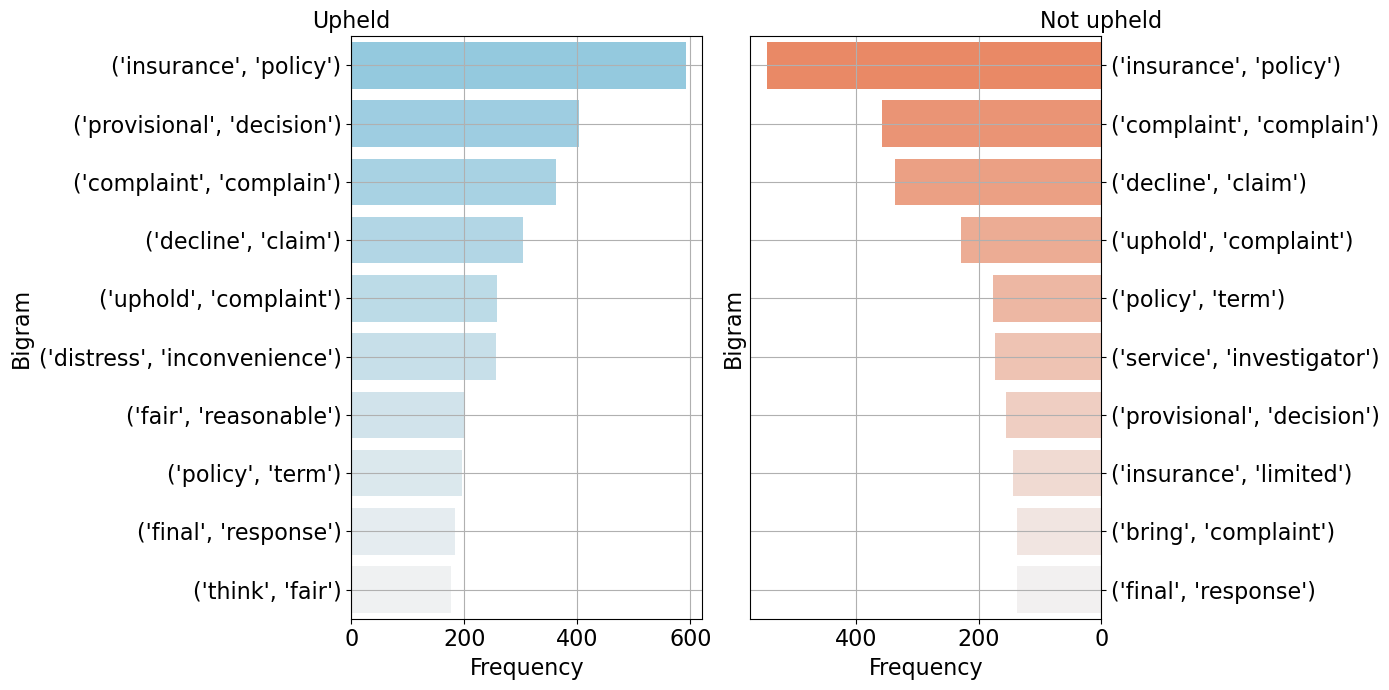

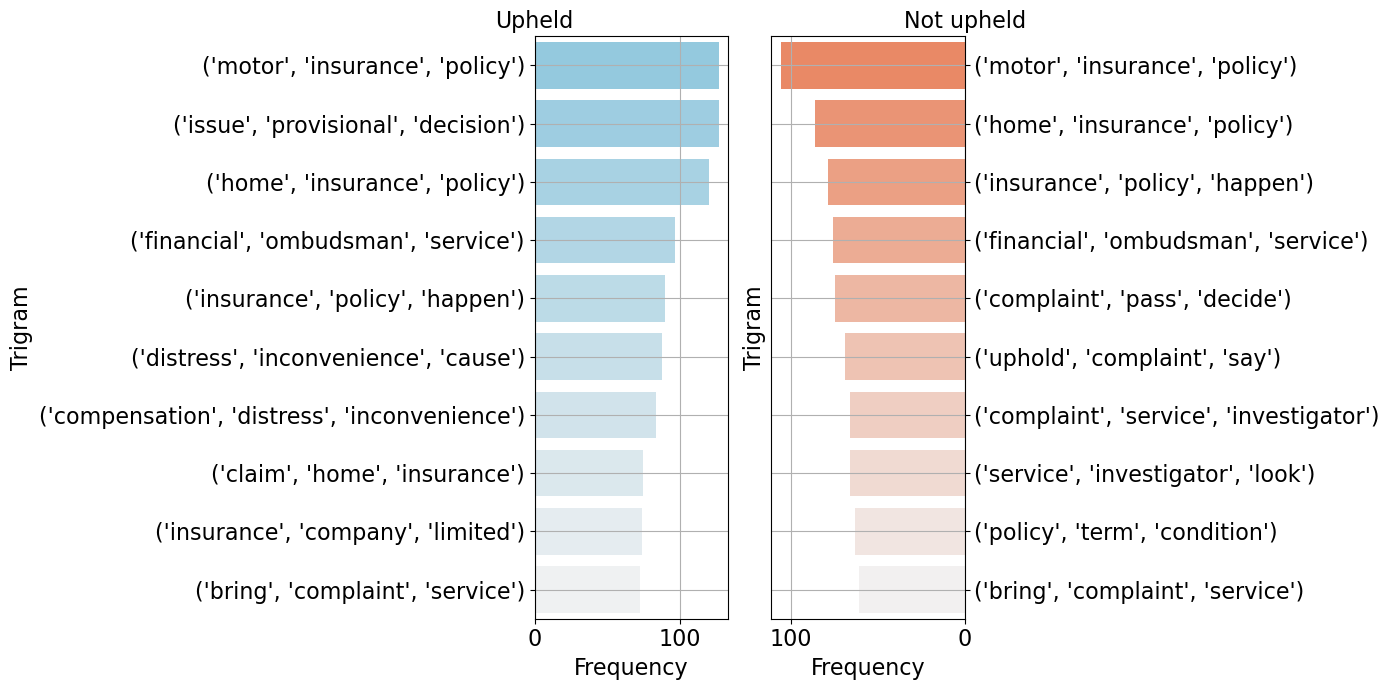

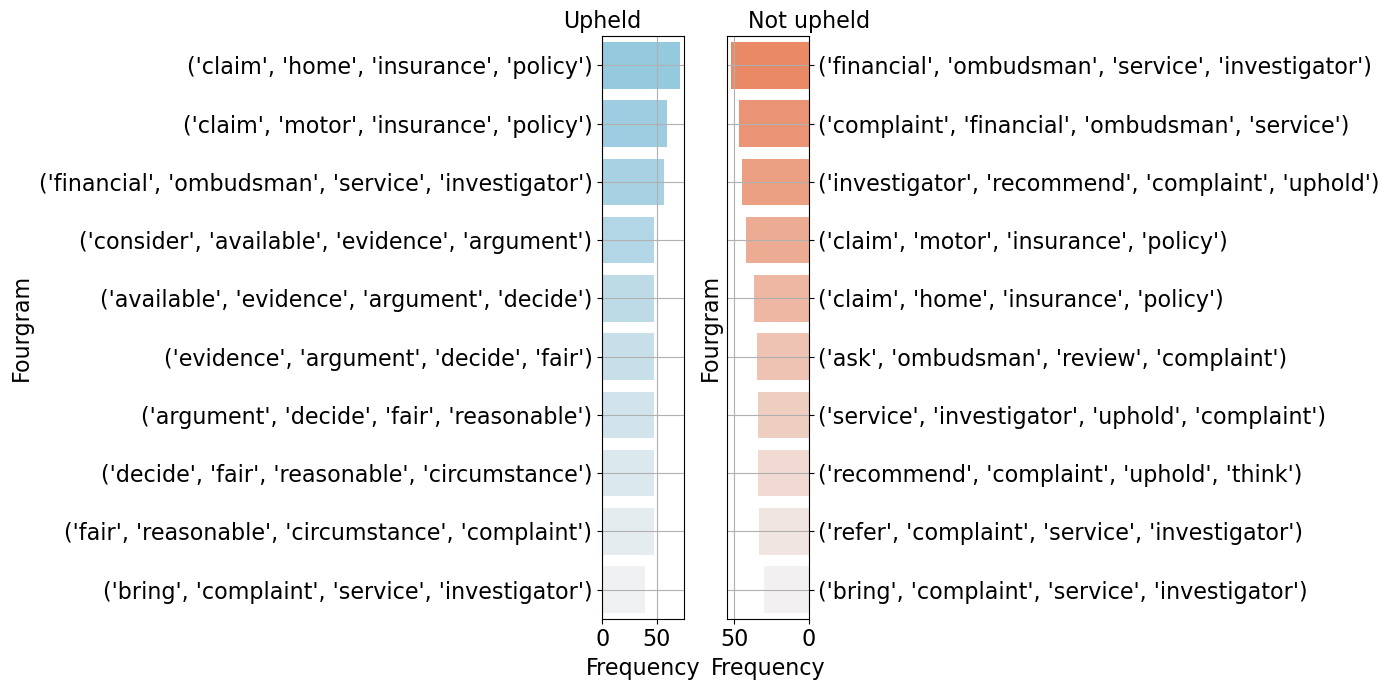

In [6]:
# function to plot n-grams
def plot_ngrams(positive_ngrams, negative_ngrams, ngram_name, num_ngrams=10):
    fig, axs = plt.subplots(1, 2, figsize=(14, 7))
    
    # positive n-grams
    positive_ngram_df = pd.DataFrame(positive_ngrams.most_common(num_ngrams), columns=[ngram_name, 'Frequency'])
    sns.barplot(x='Frequency', y=ngram_name, data=positive_ngram_df, ax=axs[0], palette='light:skyblue_r')
    # axs[0].set_title(f'Top {num_ngrams} {ngram_name}s (Upheld)', fontsize=16)
    # SET TO RIGHT
    axs[0].set_title(f'Upheld', fontsize=16)
    axs[0].set_xlabel('Frequency', fontsize=16)
    axs[0].set_ylabel(ngram_name, fontsize=16)
    axs[0].tick_params(axis='both', which='major', labelsize=16)
    axs[0].grid(True)
    axs[0].title.set_position([0, 1])
    
    # negative n-grams
    negative_ngram_df = pd.DataFrame(negative_ngrams.most_common(num_ngrams), columns=[ngram_name, 'Frequency'])
    sns.barplot(x='Frequency', y=ngram_name, data=negative_ngram_df, ax=axs[1], palette='light:coral_r')
    # axs[1].set_title(f'Top {num_ngrams} {ngram_name}s (Not upheld)', fontsize=16)
    axs[1].set_title(f'Not upheld', fontsize=16)
    axs[1].set_xlabel('Frequency', fontsize=16)
    axs[1].set_ylabel(ngram_name, fontsize=16)
    axs[1].tick_params(axis='both', which='major', labelsize=16)
    axs[1].grid(True)
    axs[1].invert_xaxis()
    axs[1].yaxis.tick_right() 
    axs[1].title.set_position([1, 1])

    plt.tight_layout()

    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    filename = "eda-" + ngram_name.replace(" ", "-")
    plt.savefig(f'plots/{filename}.png', dpi=300, bbox_inches='tight')
    plt.show()

# plot unigrams
plot_ngrams(positive_unigrams, negative_unigrams, 'Unigram')

# plot bigrams
plot_ngrams(positive_bigrams, negative_bigrams, 'Bigram')

# plot trigrams
plot_ngrams(positive_trigrams, negative_trigrams, 'Trigram')

# plot fourgrams
plot_ngrams(positive_fourgrams, negative_fourgrams, 'Fourgram')

## Name Entity Recognition

In [7]:

# print the labels
print(nlp.get_pipe('ner').labels)
# ('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE',
#  'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT',
#  'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


('CARDINAL', 'DATE', 'EVENT', 'FAC', 'GPE', 'LANGUAGE', 'LAW', 'LOC', 'MONEY', 'NORP', 'ORDINAL', 'ORG', 'PERCENT', 'PERSON', 'PRODUCT', 'QUANTITY', 'TIME', 'WORK_OF_ART')


### Class-wise Distribution

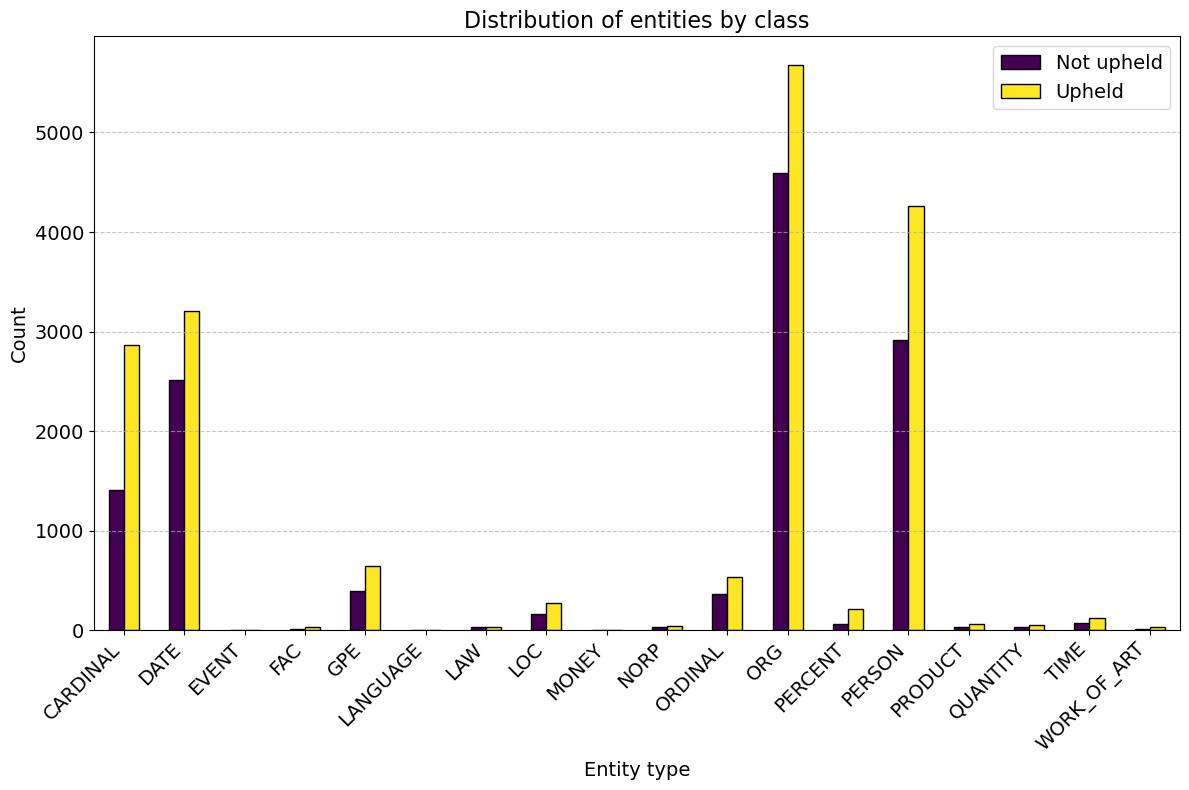

In [8]:
def extract_entities_with_labels(docs, labels):
    entities_with_labels = []
    for doc, label in zip(docs, labels):
        entities_with_labels.extend([(ent.text, ent.label_, label) for ent in doc.ents])
    return entities_with_labels

entities_with_labels = extract_entities_with_labels(train_docs_backup, train_labels)
entities_with_labels_df = pd.DataFrame(entities_with_labels, columns=['Entity', 'Type', 'Class'])

# compare entity counts between classes
class_entity_counts = entities_with_labels_df.groupby(['Class', 'Type']).size().unstack(fill_value=0)

# function to plot entity distribution by class
def plot_entity_distribution_by_class(class_entity_counts):
    ax = class_entity_counts.T.plot(kind='bar', stacked=False, figsize=(12, 8),colormap='viridis', edgecolor='black' )
    
    plt.xlabel('Entity type', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title('Distribution of entities by class', fontsize=16)
    plt.xticks(rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(title='class', fontsize=14, title_fontsize='14', loc='upper right')
    ax.legend(['Not upheld', 'Upheld'], fontsize=14, title_fontsize='14', loc='upper right')
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()

    # save the plot
    if not os.path.exists('plots'):
        os.makedirs('plots')
    plt.savefig('plots/eda-entity-distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_entity_distribution_by_class(class_entity_counts)

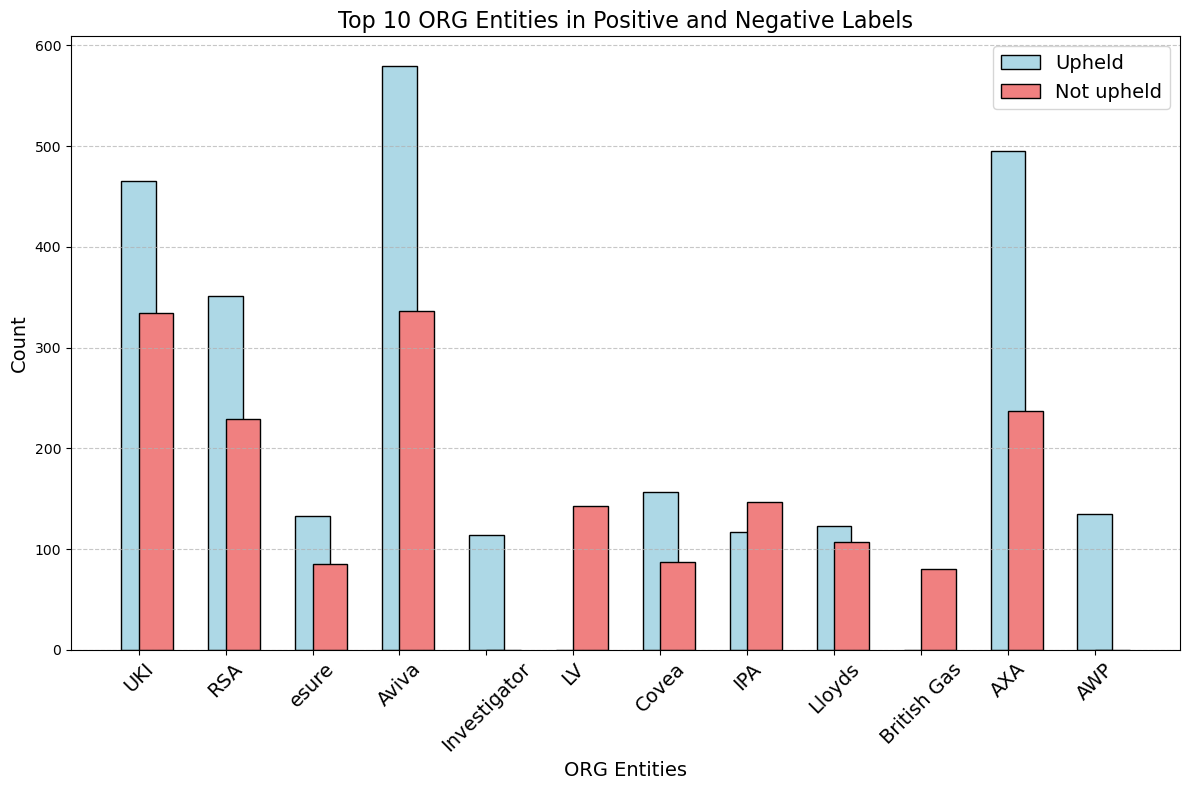

In [9]:
def plot_top_entities(entities_with_labels, entity_type, top_n=10):
    # filter entities by type and their text labels
    entities_with_labels_filtered = [(entity, text_label) for entity, entity_label, text_label in entities_with_labels if entity_label == entity_type]
    
    # count occurrences of each entity based on label positivity
    entity_counts = {
        1: Counter([entity for entity, label in entities_with_labels_filtered if label == 1]),
        0: Counter([entity for entity, label in entities_with_labels_filtered if label == 0])
    }
    
    # identify top n entities for positive and negative labels
    top_entities_positive = dict(entity_counts[1].most_common(top_n))
    top_entities_negative = dict(entity_counts[0].most_common(top_n))
    
    # extract unique entities from top lists
    unique_entities = set(top_entities_positive.keys()).union(set(top_entities_negative.keys()))
    
    # prepare count data for plotting
    positive_counts = [top_entities_positive.get(entity, 0) for entity in unique_entities]
    negative_counts = [top_entities_negative.get(entity, 0) for entity in unique_entities]
    
    # setup plot
    x = range(len(unique_entities))
    plt.figure(figsize=(12, 8))

    # define colors for bars
    bar_colors_positive = ['lightblue'] * len(unique_entities)
    bar_colors_negative = ['lightcoral'] * len(unique_entities)
    
    # create bar plots
    plt.bar(x, positive_counts, width=0.4, label='Upheld', align='center', color=bar_colors_positive, edgecolor='black')
    plt.bar(x, negative_counts, width=0.4, label='Not upheld', align='edge', color=bar_colors_negative, edgecolor='black')
    
    # set titles and labels
    plt.xlabel(f'{entity_type} Entities', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.title(f'Top {top_n} {entity_type} Entities in Positive and Negative Labels', fontsize=16)
    plt.xticks(x, unique_entities, rotation=45, fontsize=14)
    plt.legend(fontsize=14, title_fontsize='14')
    
    # add grid and adjust layout
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    
    # add spacing between bars
    plt.gca().margins(x=0.05)

    # save plot if directory does not exist
    if not os.path.exists('plots'):
        os.makedirs('plots')
    filename = "eda-" + "NER-" + entity_type.replace(" ", "-") + "-top-entities"
    plt.savefig(f'plots/{filename}.png', dpi=300, bbox_inches='tight')

    plt.show()

# plot top 'ORG' entities
plot_top_entities(entities_with_labels, 'ORG')